# Information of Data

In [122]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [123]:
data=pd.read_csv("ACME-HappinessSurvey2020.csv").copy()


In [124]:
data.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


There is no null value in the data.
All of the variables are categorical variables.

In [126]:
print(data["Y"][data["Y"]==0].count())
print(data["Y"][data["Y"]==1].count())

57
69


There is no huge amount of unbalancing in the data.

# Data Viziualization

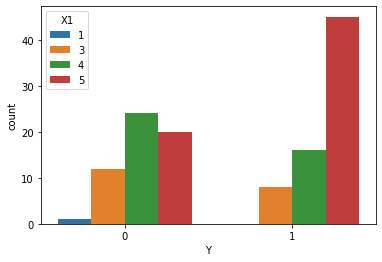

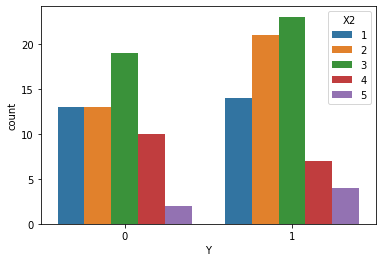

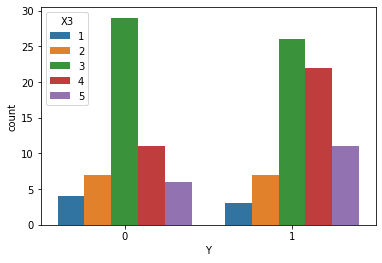

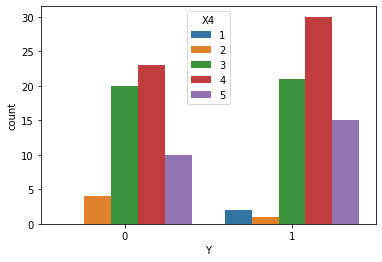

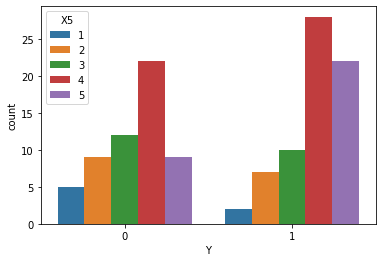

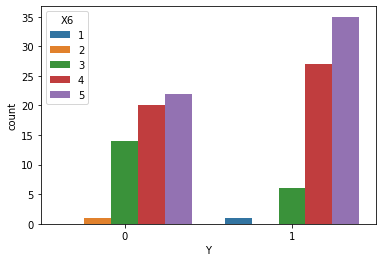

In [127]:
#fig, ax =plt.subplots(6,1,figsize=(40,40))
for i in range(1,7):
    sns.countplot( "Y", hue=data.iloc[:,i],data=data)
    plt.show()
  
    


I had the variable values plotted according to the target variable. If we look at the plots, we can see that association between target and variables. For example, for X1, the class 5 has approximately 45 value for target 1, but has 20 value for target 0. The difference is nearly twice between each other. So, this variable (X1), can be effect on our model.

# Splitting The Data

In [128]:
y=data["Y"]
data=data.drop("Y", axis=1)


In [202]:
X_train, X_test, y_train,y_test=train_test_split(data,y,test_size=0.15,random_state=42)

I set the test size small, because the data has little sample.

# Model

In [9]:
def result(model,X_train,X_test,y_train,y_test):
    print( "\033[1m","         ****** RESULT ****** ", "\033[0;0m")
    y_pred = model.predict(X_test)
    print("\033[1m","TEST Accuracy=","\033[0m",accuracy_score(y_test, y_pred))
    print("\033[1m","TEST Report=\n","\033[0m",classification_report(y_test,model.predict(X_test)),"\n")
    print("\033[1m","confusion matrix=\n","\033[0m",confusion_matrix(y_pred,y_test),"\n")
    y_pred = model.predict(X_train)
    print("\033[1m","TRAIN Accuracy=","\033[0m",accuracy_score(y_train, y_pred))
    print("\033[1m","TRAIN Report=\n","\033[0m",classification_report(y_train,model.predict(X_train)),"\n")
    print("\033[1m","confusion matrix=\n","\033[0m",confusion_matrix(y_pred,y_train),"\n")
    
    
   

I tried Naive Bayes algorithm and it had no good value. For modelling I will apply trees because data has small size and small dimensions. I will use Gradient Boosting and Cat Boost Classifier.(Cat boost has good effects on the data that has categorical variables)

### Gradiend Boosting 

In [100]:
from sklearn.ensemble import GradientBoostingClassifier

In [203]:
gbm_model = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)

In [204]:
result(gbm_model,X_train,X_test,y_train,y_test)

          ****** RESULT ******  
 TEST Accuracy=  0.7368421052631579
 TEST Report=
                precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.67      0.89      0.76         9

    accuracy                           0.74        19
   macro avg       0.76      0.74      0.73        19
weighted avg       0.77      0.74      0.73        19
 

 confusion matrix=
  [[6 1]
 [4 8]] 

 TRAIN Accuracy=  0.8785046728971962
 TRAIN Report=
                precision    recall  f1-score   support

           0       0.95      0.77      0.85        47
           1       0.84      0.97      0.90        60

    accuracy                           0.88       107
   macro avg       0.89      0.87      0.87       107
weighted avg       0.89      0.88      0.88       107
 

 confusion matrix=
  [[36  2]
 [11 58]] 



***There is a huge overfit.***

#### Feature Importance of GBM

In [205]:
Importance=pd.DataFrame({"Importance":gbm_model.feature_importances_*100},
                       index=X_train.columns)

Text(0.5, 0, 'Değişken Önem düzeyleri')

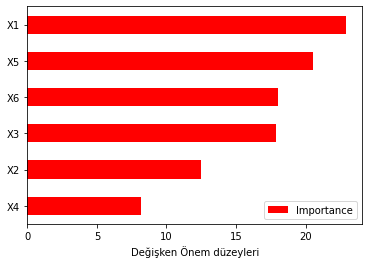

In [206]:
Importance.sort_values(by="Importance",
                      axis=0,
                      ascending=True).plot(kind="barh",color="r")
plt.xlabel("Değişken Önem düzeyleri")

***I will select the features X1,X3,X5,X6. Because after X3, there is a big decreasing rate in the importance.***

In [207]:
X_train2=X_train[["X1","X3","X5","X6"]]
X_test2=X_test[["X1","X3","X5","X6"]]

#### GBM Tuning

In [210]:
gbm_params = {"learning_rate" : [ 0.01, 0.03, 0.1,0.3],
             "n_estimators":range(300,1201,200),
             "max_depth": [3,5,7],
             }

In [211]:
gbm = GradientBoostingClassifier()

In [212]:
gbm_cv = GridSearchCV(gbm, gbm_params, cv = 3, n_jobs = -1, verbose = 2)
gbm_cv.fit(X_train2, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.3min finished


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.03, 0.1, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': range(300, 1201, 200)},
             verbose=2)

In [213]:
gbm_cv.best_params_

{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300}

In [215]:
gbm = GradientBoostingClassifier(learning_rate=0.01,
                                 max_depth = 7,
                                n_estimators = 700,
                                random_state=42                              
                                 
                                )

In [216]:
gbm_tuned =  gbm.fit(X_train2,y_train)
result(gbm_tuned,X_train2,X_test2,y_train,y_test)

          ****** RESULT ******  
 TEST Accuracy=  0.7894736842105263
 TEST Report=
                precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19
 

 confusion matrix=
  [[7 1]
 [3 8]] 

 TRAIN Accuracy=  0.822429906542056
 TRAIN Report=
                precision    recall  f1-score   support

           0       0.89      0.68      0.77        47
           1       0.79      0.93      0.85        60

    accuracy                           0.82       107
   macro avg       0.84      0.81      0.81       107
weighted avg       0.83      0.82      0.82       107
 

 confusion matrix=
  [[32  4]
 [15 56]] 



***As you can see, in the result accuracy of test was increased.***

### CatBoost

In [217]:
from catboost import CatBoostClassifier

In [218]:
catboost = CatBoostClassifier(random_state=42)
catboost.fit(X_train, y_train)

Learning rate set to 0.003967
0:	learn: 0.6918120	total: 2.71ms	remaining: 2.71s
1:	learn: 0.6906043	total: 5.88ms	remaining: 2.94s
2:	learn: 0.6893388	total: 8.55ms	remaining: 2.84s
3:	learn: 0.6881577	total: 11.8ms	remaining: 2.94s
4:	learn: 0.6865166	total: 14.5ms	remaining: 2.88s
5:	learn: 0.6857469	total: 16.7ms	remaining: 2.76s
6:	learn: 0.6849124	total: 19.8ms	remaining: 2.81s
7:	learn: 0.6840646	total: 22.8ms	remaining: 2.83s
8:	learn: 0.6834619	total: 25.2ms	remaining: 2.77s
9:	learn: 0.6826430	total: 27.9ms	remaining: 2.77s
10:	learn: 0.6815788	total: 30.6ms	remaining: 2.75s
11:	learn: 0.6807433	total: 33.8ms	remaining: 2.78s
12:	learn: 0.6797707	total: 36.6ms	remaining: 2.78s
13:	learn: 0.6785445	total: 39.2ms	remaining: 2.76s
14:	learn: 0.6781814	total: 41.6ms	remaining: 2.73s
15:	learn: 0.6771556	total: 44.3ms	remaining: 2.72s
16:	learn: 0.6758699	total: 47.2ms	remaining: 2.73s
17:	learn: 0.6748975	total: 49.8ms	remaining: 2.72s
18:	learn: 0.6739880	total: 52.6ms	remaining

160:	learn: 0.5735338	total: 451ms	remaining: 2.35s
161:	learn: 0.5727816	total: 456ms	remaining: 2.36s
162:	learn: 0.5720508	total: 459ms	remaining: 2.35s
163:	learn: 0.5713140	total: 462ms	remaining: 2.35s
164:	learn: 0.5707867	total: 465ms	remaining: 2.35s
165:	learn: 0.5703905	total: 468ms	remaining: 2.35s
166:	learn: 0.5699121	total: 470ms	remaining: 2.34s
167:	learn: 0.5693509	total: 472ms	remaining: 2.34s
168:	learn: 0.5690326	total: 474ms	remaining: 2.33s
169:	learn: 0.5686518	total: 477ms	remaining: 2.33s
170:	learn: 0.5682693	total: 480ms	remaining: 2.33s
171:	learn: 0.5676322	total: 484ms	remaining: 2.33s
172:	learn: 0.5668752	total: 486ms	remaining: 2.32s
173:	learn: 0.5663665	total: 489ms	remaining: 2.32s
174:	learn: 0.5660261	total: 494ms	remaining: 2.33s
175:	learn: 0.5651511	total: 496ms	remaining: 2.32s
176:	learn: 0.5646505	total: 499ms	remaining: 2.32s
177:	learn: 0.5642097	total: 502ms	remaining: 2.32s
178:	learn: 0.5637243	total: 504ms	remaining: 2.31s
179:	learn: 

361:	learn: 0.4924144	total: 1.05s	remaining: 1.86s
362:	learn: 0.4919630	total: 1.06s	remaining: 1.85s
363:	learn: 0.4915601	total: 1.06s	remaining: 1.85s
364:	learn: 0.4914983	total: 1.06s	remaining: 1.85s
365:	learn: 0.4913851	total: 1.06s	remaining: 1.84s
366:	learn: 0.4908807	total: 1.07s	remaining: 1.84s
367:	learn: 0.4905409	total: 1.07s	remaining: 1.83s
368:	learn: 0.4902871	total: 1.07s	remaining: 1.83s
369:	learn: 0.4902426	total: 1.07s	remaining: 1.82s
370:	learn: 0.4898357	total: 1.07s	remaining: 1.82s
371:	learn: 0.4894525	total: 1.08s	remaining: 1.82s
372:	learn: 0.4889944	total: 1.08s	remaining: 1.82s
373:	learn: 0.4888429	total: 1.08s	remaining: 1.81s
374:	learn: 0.4885485	total: 1.09s	remaining: 1.81s
375:	learn: 0.4881190	total: 1.09s	remaining: 1.81s
376:	learn: 0.4877506	total: 1.09s	remaining: 1.8s
377:	learn: 0.4875278	total: 1.09s	remaining: 1.8s
378:	learn: 0.4871692	total: 1.1s	remaining: 1.8s
379:	learn: 0.4870296	total: 1.1s	remaining: 1.79s
380:	learn: 0.486

544:	learn: 0.4429587	total: 1.51s	remaining: 1.26s
545:	learn: 0.4428531	total: 1.51s	remaining: 1.25s
546:	learn: 0.4426305	total: 1.51s	remaining: 1.25s
547:	learn: 0.4424136	total: 1.51s	remaining: 1.25s
548:	learn: 0.4420915	total: 1.52s	remaining: 1.25s
549:	learn: 0.4418745	total: 1.52s	remaining: 1.24s
550:	learn: 0.4415974	total: 1.52s	remaining: 1.24s
551:	learn: 0.4413629	total: 1.52s	remaining: 1.24s
552:	learn: 0.4413369	total: 1.52s	remaining: 1.23s
553:	learn: 0.4409690	total: 1.53s	remaining: 1.23s
554:	learn: 0.4409498	total: 1.53s	remaining: 1.23s
555:	learn: 0.4409261	total: 1.53s	remaining: 1.22s
556:	learn: 0.4406473	total: 1.53s	remaining: 1.22s
557:	learn: 0.4404988	total: 1.53s	remaining: 1.22s
558:	learn: 0.4402906	total: 1.54s	remaining: 1.21s
559:	learn: 0.4400229	total: 1.54s	remaining: 1.21s
560:	learn: 0.4399888	total: 1.54s	remaining: 1.21s
561:	learn: 0.4397117	total: 1.54s	remaining: 1.2s
562:	learn: 0.4393198	total: 1.55s	remaining: 1.2s
563:	learn: 0.

747:	learn: 0.4040604	total: 1.98s	remaining: 666ms
748:	learn: 0.4040140	total: 1.98s	remaining: 663ms
749:	learn: 0.4036653	total: 1.98s	remaining: 660ms
750:	learn: 0.4034543	total: 1.98s	remaining: 657ms
751:	learn: 0.4032364	total: 1.98s	remaining: 655ms
752:	learn: 0.4030188	total: 1.99s	remaining: 652ms
753:	learn: 0.4029705	total: 1.99s	remaining: 649ms
754:	learn: 0.4028716	total: 1.99s	remaining: 646ms
755:	learn: 0.4026148	total: 1.99s	remaining: 644ms
756:	learn: 0.4024070	total: 2s	remaining: 641ms
757:	learn: 0.4023052	total: 2s	remaining: 638ms
758:	learn: 0.4020151	total: 2s	remaining: 635ms
759:	learn: 0.4018475	total: 2s	remaining: 632ms
760:	learn: 0.4016933	total: 2s	remaining: 630ms
761:	learn: 0.4014501	total: 2.01s	remaining: 627ms
762:	learn: 0.4011332	total: 2.01s	remaining: 624ms
763:	learn: 0.4009807	total: 2.01s	remaining: 622ms
764:	learn: 0.4008301	total: 2.02s	remaining: 619ms
765:	learn: 0.4005274	total: 2.02s	remaining: 617ms
766:	learn: 0.4002199	total

926:	learn: 0.3737873	total: 2.42s	remaining: 191ms
927:	learn: 0.3737640	total: 2.42s	remaining: 188ms
928:	learn: 0.3734064	total: 2.43s	remaining: 186ms
929:	learn: 0.3733672	total: 2.43s	remaining: 183ms
930:	learn: 0.3731378	total: 2.43s	remaining: 180ms
931:	learn: 0.3731307	total: 2.44s	remaining: 178ms
932:	learn: 0.3729629	total: 2.44s	remaining: 175ms
933:	learn: 0.3728059	total: 2.44s	remaining: 173ms
934:	learn: 0.3726751	total: 2.44s	remaining: 170ms
935:	learn: 0.3725618	total: 2.45s	remaining: 167ms
936:	learn: 0.3724757	total: 2.45s	remaining: 165ms
937:	learn: 0.3721790	total: 2.45s	remaining: 162ms
938:	learn: 0.3720644	total: 2.46s	remaining: 160ms
939:	learn: 0.3720510	total: 2.46s	remaining: 157ms
940:	learn: 0.3718065	total: 2.46s	remaining: 154ms
941:	learn: 0.3717409	total: 2.46s	remaining: 152ms
942:	learn: 0.3715377	total: 2.46s	remaining: 149ms
943:	learn: 0.3713038	total: 2.47s	remaining: 146ms
944:	learn: 0.3711097	total: 2.47s	remaining: 144ms
945:	learn: 

In [219]:
result(catboost,X_train,X_test,y_train,y_test)

          ****** RESULT ******  
 TEST Accuracy=  0.6842105263157895
 TEST Report=
                precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.62      0.89      0.73         9

    accuracy                           0.68        19
   macro avg       0.72      0.69      0.68        19
weighted avg       0.73      0.68      0.67        19
 

 confusion matrix=
  [[5 1]
 [5 8]] 

 TRAIN Accuracy=  0.897196261682243
 TRAIN Report=
                precision    recall  f1-score   support

           0       1.00      0.77      0.87        47
           1       0.85      1.00      0.92        60

    accuracy                           0.90       107
   macro avg       0.92      0.88      0.89       107
weighted avg       0.91      0.90      0.89       107
 

 confusion matrix=
  [[36  0]
 [11 60]] 



***There is a huge overfitting again.***

#### Feature Elimination of CatBoost

In [220]:
Importance=pd.DataFrame({"Importance":catboost.feature_importances_*100},
                       index=X_train.columns)

Text(0.5, 0, 'Değişken Önem düzeyleri')

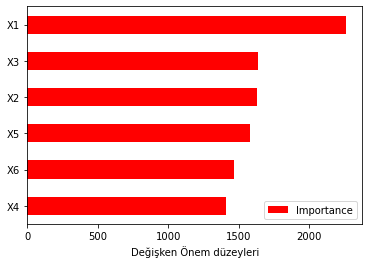

In [221]:
Importance.sort_values(by="Importance",
                      axis=0,
                      ascending=True).plot(kind="barh",color="r")
plt.xlabel("Değişken Önem düzeyleri")

***In the result, there is no important difference between variables. So I will use features that was selected with GBM (X1,X3,X5,X6)***

In [223]:
catboost2=CatBoostClassifier(random_state=42)
catboost2.fit(X_train2, y_train) 


Learning rate set to 0.003967
0:	learn: 0.6919639	total: 2.67ms	remaining: 2.67s
1:	learn: 0.6906524	total: 5.98ms	remaining: 2.98s
2:	learn: 0.6895429	total: 9.39ms	remaining: 3.12s
3:	learn: 0.6892773	total: 11.7ms	remaining: 2.91s
4:	learn: 0.6884393	total: 15.6ms	remaining: 3.1s
5:	learn: 0.6872458	total: 19.3ms	remaining: 3.2s
6:	learn: 0.6859540	total: 23.3ms	remaining: 3.3s
7:	learn: 0.6850763	total: 26.2ms	remaining: 3.25s
8:	learn: 0.6840734	total: 28.9ms	remaining: 3.18s
9:	learn: 0.6836499	total: 30.7ms	remaining: 3.04s
10:	learn: 0.6823694	total: 33.2ms	remaining: 2.98s
11:	learn: 0.6816128	total: 35.6ms	remaining: 2.94s
12:	learn: 0.6803936	total: 38.6ms	remaining: 2.93s
13:	learn: 0.6795464	total: 40.9ms	remaining: 2.88s
14:	learn: 0.6783993	total: 43.9ms	remaining: 2.88s
15:	learn: 0.6772559	total: 47.3ms	remaining: 2.91s
16:	learn: 0.6760512	total: 51.1ms	remaining: 2.95s
17:	learn: 0.6754329	total: 66.1ms	remaining: 3.6s
18:	learn: 0.6747564	total: 69.5ms	remaining: 3.

202:	learn: 0.5684640	total: 578ms	remaining: 2.27s
203:	learn: 0.5680777	total: 580ms	remaining: 2.26s
204:	learn: 0.5673388	total: 582ms	remaining: 2.26s
205:	learn: 0.5669458	total: 585ms	remaining: 2.25s
206:	learn: 0.5666362	total: 588ms	remaining: 2.25s
207:	learn: 0.5665086	total: 590ms	remaining: 2.25s
208:	learn: 0.5662947	total: 592ms	remaining: 2.24s
209:	learn: 0.5657781	total: 594ms	remaining: 2.23s
210:	learn: 0.5650546	total: 596ms	remaining: 2.23s
211:	learn: 0.5645162	total: 598ms	remaining: 2.22s
212:	learn: 0.5643704	total: 601ms	remaining: 2.22s
213:	learn: 0.5636207	total: 605ms	remaining: 2.22s
214:	learn: 0.5633204	total: 608ms	remaining: 2.22s
215:	learn: 0.5632088	total: 611ms	remaining: 2.22s
216:	learn: 0.5629111	total: 613ms	remaining: 2.21s
217:	learn: 0.5625937	total: 616ms	remaining: 2.21s
218:	learn: 0.5624107	total: 619ms	remaining: 2.21s
219:	learn: 0.5618806	total: 621ms	remaining: 2.2s
220:	learn: 0.5615331	total: 624ms	remaining: 2.2s
221:	learn: 0.

368:	learn: 0.5206530	total: 1.02s	remaining: 1.74s
369:	learn: 0.5204558	total: 1.02s	remaining: 1.74s
370:	learn: 0.5204146	total: 1.02s	remaining: 1.74s
371:	learn: 0.5202952	total: 1.03s	remaining: 1.73s
372:	learn: 0.5199621	total: 1.03s	remaining: 1.73s
373:	learn: 0.5195632	total: 1.03s	remaining: 1.73s
374:	learn: 0.5192865	total: 1.04s	remaining: 1.73s
375:	learn: 0.5189761	total: 1.04s	remaining: 1.73s
376:	learn: 0.5186796	total: 1.05s	remaining: 1.73s
377:	learn: 0.5184489	total: 1.05s	remaining: 1.73s
378:	learn: 0.5183325	total: 1.05s	remaining: 1.72s
379:	learn: 0.5181290	total: 1.05s	remaining: 1.72s
380:	learn: 0.5180160	total: 1.06s	remaining: 1.72s
381:	learn: 0.5179761	total: 1.06s	remaining: 1.71s
382:	learn: 0.5176517	total: 1.06s	remaining: 1.71s
383:	learn: 0.5173564	total: 1.07s	remaining: 1.71s
384:	learn: 0.5171071	total: 1.07s	remaining: 1.71s
385:	learn: 0.5169875	total: 1.07s	remaining: 1.71s
386:	learn: 0.5169313	total: 1.07s	remaining: 1.7s
387:	learn: 0

575:	learn: 0.4860677	total: 1.6s	remaining: 1.18s
576:	learn: 0.4859925	total: 1.61s	remaining: 1.18s
577:	learn: 0.4859867	total: 1.61s	remaining: 1.17s
578:	learn: 0.4857220	total: 1.61s	remaining: 1.17s
579:	learn: 0.4855674	total: 1.61s	remaining: 1.17s
580:	learn: 0.4852792	total: 1.62s	remaining: 1.17s
581:	learn: 0.4850996	total: 1.62s	remaining: 1.16s
582:	learn: 0.4849597	total: 1.62s	remaining: 1.16s
583:	learn: 0.4848739	total: 1.63s	remaining: 1.16s
584:	learn: 0.4846515	total: 1.63s	remaining: 1.16s
585:	learn: 0.4845362	total: 1.63s	remaining: 1.15s
586:	learn: 0.4844771	total: 1.64s	remaining: 1.15s
587:	learn: 0.4843283	total: 1.64s	remaining: 1.15s
588:	learn: 0.4843192	total: 1.64s	remaining: 1.15s
589:	learn: 0.4842124	total: 1.65s	remaining: 1.14s
590:	learn: 0.4840444	total: 1.65s	remaining: 1.14s
591:	learn: 0.4838377	total: 1.65s	remaining: 1.14s
592:	learn: 0.4837355	total: 1.65s	remaining: 1.14s
593:	learn: 0.4835471	total: 1.66s	remaining: 1.13s
594:	learn: 0

734:	learn: 0.4656637	total: 2.06s	remaining: 744ms
735:	learn: 0.4656314	total: 2.06s	remaining: 741ms
736:	learn: 0.4654289	total: 2.07s	remaining: 738ms
737:	learn: 0.4653835	total: 2.07s	remaining: 735ms
738:	learn: 0.4653272	total: 2.07s	remaining: 733ms
739:	learn: 0.4653164	total: 2.08s	remaining: 730ms
740:	learn: 0.4651424	total: 2.08s	remaining: 728ms
741:	learn: 0.4649873	total: 2.08s	remaining: 725ms
742:	learn: 0.4647815	total: 2.09s	remaining: 722ms
743:	learn: 0.4646292	total: 2.09s	remaining: 720ms
744:	learn: 0.4645154	total: 2.09s	remaining: 716ms
745:	learn: 0.4642974	total: 2.1s	remaining: 714ms
746:	learn: 0.4642878	total: 2.1s	remaining: 711ms
747:	learn: 0.4642777	total: 2.1s	remaining: 708ms
748:	learn: 0.4641653	total: 2.1s	remaining: 705ms
749:	learn: 0.4640892	total: 2.11s	remaining: 702ms
750:	learn: 0.4640676	total: 2.11s	remaining: 699ms
751:	learn: 0.4639445	total: 2.11s	remaining: 697ms
752:	learn: 0.4639424	total: 2.12s	remaining: 694ms
753:	learn: 0.46

934:	learn: 0.4456239	total: 2.65s	remaining: 184ms
935:	learn: 0.4455250	total: 2.65s	remaining: 181ms
936:	learn: 0.4455241	total: 2.65s	remaining: 178ms
937:	learn: 0.4454803	total: 2.65s	remaining: 176ms
938:	learn: 0.4454541	total: 2.66s	remaining: 173ms
939:	learn: 0.4452947	total: 2.66s	remaining: 170ms
940:	learn: 0.4452233	total: 2.67s	remaining: 167ms
941:	learn: 0.4451316	total: 2.67s	remaining: 164ms
942:	learn: 0.4450535	total: 2.67s	remaining: 161ms
943:	learn: 0.4449648	total: 2.67s	remaining: 159ms
944:	learn: 0.4447748	total: 2.68s	remaining: 156ms
945:	learn: 0.4447576	total: 2.68s	remaining: 153ms
946:	learn: 0.4447307	total: 2.68s	remaining: 150ms
947:	learn: 0.4446549	total: 2.69s	remaining: 147ms
948:	learn: 0.4446431	total: 2.69s	remaining: 145ms
949:	learn: 0.4444845	total: 2.69s	remaining: 142ms
950:	learn: 0.4444836	total: 2.69s	remaining: 139ms
951:	learn: 0.4444808	total: 2.7s	remaining: 136ms
952:	learn: 0.4443363	total: 2.7s	remaining: 133ms
953:	learn: 0.

In [224]:
result(catboost2,X_train,X_test,y_train,y_test)

          ****** RESULT ******  
 TEST Accuracy=  0.7368421052631579
 TEST Report=
                precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.70      0.78      0.74         9

    accuracy                           0.74        19
   macro avg       0.74      0.74      0.74        19
weighted avg       0.74      0.74      0.74        19
 

 confusion matrix=
  [[7 2]
 [3 7]] 

 TRAIN Accuracy=  0.822429906542056
 TRAIN Report=
                precision    recall  f1-score   support

           0       0.91      0.66      0.77        47
           1       0.78      0.95      0.86        60

    accuracy                           0.82       107
   macro avg       0.85      0.80      0.81       107
weighted avg       0.84      0.82      0.82       107
 

 confusion matrix=
  [[31  3]
 [16 57]] 



***In the result, you can see that chosing X1,X3,X5 and X6 has good effect.***

#### CatBoost Tuning

In [231]:
catboost_params = {"learning_rate" : [ 0.01, 0.03, 0.1,0.3],
             "iterations":range(300,1201,200),
             "depth": [3,5,7],
             }

In [232]:
catboost_grid=CatBoostClassifier()

In [234]:
grid = GridSearchCV(estimator=catboost_grid, param_grid = catboost_params, cv = 3, n_jobs=-1)
grid.fit(X_train2, y_train)    

0:	learn: 0.6918059	total: 1.99ms	remaining: 594ms
1:	learn: 0.6893730	total: 4.91ms	remaining: 731ms
2:	learn: 0.6870864	total: 7.22ms	remaining: 715ms
3:	learn: 0.6846041	total: 9.48ms	remaining: 702ms
4:	learn: 0.6834346	total: 11.6ms	remaining: 686ms
5:	learn: 0.6806928	total: 14.6ms	remaining: 714ms
6:	learn: 0.6792466	total: 17ms	remaining: 711ms
7:	learn: 0.6770579	total: 19.5ms	remaining: 712ms
8:	learn: 0.6750359	total: 22.1ms	remaining: 716ms
9:	learn: 0.6730474	total: 24.7ms	remaining: 716ms
10:	learn: 0.6704712	total: 27.2ms	remaining: 715ms
11:	learn: 0.6686012	total: 29.6ms	remaining: 711ms
12:	learn: 0.6677118	total: 31.7ms	remaining: 699ms
13:	learn: 0.6671540	total: 33.7ms	remaining: 687ms
14:	learn: 0.6658606	total: 36.2ms	remaining: 688ms
15:	learn: 0.6635289	total: 38.9ms	remaining: 690ms
16:	learn: 0.6620394	total: 41.4ms	remaining: 690ms
17:	learn: 0.6602834	total: 43.9ms	remaining: 688ms
18:	learn: 0.6599456	total: 46ms	remaining: 681ms
19:	learn: 0.6572015	total

167:	learn: 0.5227189	total: 439ms	remaining: 345ms
168:	learn: 0.5217454	total: 442ms	remaining: 342ms
169:	learn: 0.5208387	total: 447ms	remaining: 342ms
170:	learn: 0.5201519	total: 451ms	remaining: 340ms
171:	learn: 0.5197039	total: 454ms	remaining: 338ms
172:	learn: 0.5190827	total: 457ms	remaining: 336ms
173:	learn: 0.5180396	total: 461ms	remaining: 334ms
174:	learn: 0.5176180	total: 464ms	remaining: 332ms
175:	learn: 0.5167108	total: 468ms	remaining: 330ms
176:	learn: 0.5161807	total: 471ms	remaining: 328ms
177:	learn: 0.5158701	total: 474ms	remaining: 325ms
178:	learn: 0.5154066	total: 476ms	remaining: 322ms
179:	learn: 0.5153611	total: 479ms	remaining: 319ms
180:	learn: 0.5145207	total: 482ms	remaining: 317ms
181:	learn: 0.5141886	total: 485ms	remaining: 314ms
182:	learn: 0.5140133	total: 487ms	remaining: 312ms
183:	learn: 0.5139041	total: 490ms	remaining: 309ms
184:	learn: 0.5138812	total: 492ms	remaining: 306ms
185:	learn: 0.5137137	total: 494ms	remaining: 303ms
186:	learn: 

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000000000DCF1288>,
             n_jobs=-1,
             param_grid={'depth': [3, 5, 7],
                         'iterations': range(300, 1201, 200),
                         'learning_rate': [0.01, 0.03, 0.1, 0.3]})

In [240]:
grid.best_params_

{'depth': 5, 'iterations': 300, 'learning_rate': 0.01}

In [241]:
catboost_grid = CatBoostClassifier(depth= 5,iterations= 300, learning_rate= 0.01)
catboost_grid.fit(X_train2, y_train)

0:	learn: 0.6918059	total: 2.03ms	remaining: 606ms
1:	learn: 0.6893730	total: 4.84ms	remaining: 721ms
2:	learn: 0.6870864	total: 7.4ms	remaining: 733ms
3:	learn: 0.6846041	total: 9.78ms	remaining: 724ms
4:	learn: 0.6834346	total: 12.3ms	remaining: 727ms
5:	learn: 0.6806928	total: 14.7ms	remaining: 720ms
6:	learn: 0.6792466	total: 16.8ms	remaining: 705ms
7:	learn: 0.6770579	total: 19.1ms	remaining: 698ms
8:	learn: 0.6750359	total: 21.1ms	remaining: 683ms
9:	learn: 0.6730474	total: 23.2ms	remaining: 673ms
10:	learn: 0.6704712	total: 25.5ms	remaining: 671ms
11:	learn: 0.6686012	total: 27.3ms	remaining: 654ms
12:	learn: 0.6677118	total: 29.2ms	remaining: 644ms
13:	learn: 0.6671540	total: 30.8ms	remaining: 629ms
14:	learn: 0.6658606	total: 33.2ms	remaining: 631ms
15:	learn: 0.6635289	total: 35.6ms	remaining: 631ms
16:	learn: 0.6620394	total: 37.9ms	remaining: 631ms
17:	learn: 0.6602834	total: 40.2ms	remaining: 629ms
18:	learn: 0.6599456	total: 42.1ms	remaining: 623ms
19:	learn: 0.6572015	to

192:	learn: 0.5109428	total: 437ms	remaining: 242ms
193:	learn: 0.5104093	total: 439ms	remaining: 240ms
194:	learn: 0.5098941	total: 442ms	remaining: 238ms
195:	learn: 0.5098066	total: 444ms	remaining: 235ms
196:	learn: 0.5096373	total: 445ms	remaining: 233ms
197:	learn: 0.5094860	total: 448ms	remaining: 231ms
198:	learn: 0.5090582	total: 450ms	remaining: 228ms
199:	learn: 0.5090254	total: 452ms	remaining: 226ms
200:	learn: 0.5082234	total: 455ms	remaining: 224ms
201:	learn: 0.5079940	total: 457ms	remaining: 222ms
202:	learn: 0.5076120	total: 459ms	remaining: 219ms
203:	learn: 0.5069529	total: 461ms	remaining: 217ms
204:	learn: 0.5068977	total: 462ms	remaining: 214ms
205:	learn: 0.5064608	total: 464ms	remaining: 212ms
206:	learn: 0.5061913	total: 466ms	remaining: 209ms
207:	learn: 0.5056878	total: 468ms	remaining: 207ms
208:	learn: 0.5048041	total: 470ms	remaining: 205ms
209:	learn: 0.5045575	total: 472ms	remaining: 202ms
210:	learn: 0.5042521	total: 474ms	remaining: 200ms
211:	learn: 

In [242]:
result(catboost_grid,X_train2,X_test2,y_train,y_test)

          ****** RESULT ******  
 TEST Accuracy=  0.7894736842105263
 TEST Report=
                precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.73      0.89      0.80         9

    accuracy                           0.79        19
   macro avg       0.80      0.79      0.79        19
weighted avg       0.81      0.79      0.79        19
 

 confusion matrix=
  [[7 1]
 [3 8]] 

 TRAIN Accuracy=  0.822429906542056
 TRAIN Report=
                precision    recall  f1-score   support

           0       0.91      0.66      0.77        47
           1       0.78      0.95      0.86        60

    accuracy                           0.82       107
   macro avg       0.85      0.80      0.81       107
weighted avg       0.84      0.82      0.82       107
 

 confusion matrix=
  [[31  3]
 [16 57]] 



# Result

***For both of the algorithms , using the features X1,X3,X6,X5 has good effect. So, these variables are enough to modelling.
After tunnings both of them has test accuracy 0.79 and train 0.82. So we can use both of them.***